# S字でリスクポテンシャルモデル

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
from matplotlib.animation import PillowWriter
import math

In [64]:
# 車両クラス
class Vehicle():
    def __init__(self, x=0, y=0, v=20/3.6, theta=0, yawrate=0):
        self.x = x
        self.y = y
        self.v = v
        self.theta = theta
        self.yawrate = yawrate

In [65]:
# シグモイド
def sigmoid(x, a=0.2, b=0, c=5):
    return c / (1 + np.exp(-(a*x+b)))

In [66]:
# 点列から曲率計算
def CalcCurvature(x,y,npo=1):
    cv=[]

    ndata=len(x)

    for i in range(ndata):
        lind=i-npo
        hind=i+npo+1

        if lind<0:
            lind=0
        if hind>=ndata:
            hind=ndata
        #  print(lind,hind)

        xs=x[lind:hind]
        ys=y[lind:hind]
        #  print(xs,ys)
        (cxe,cye,re)=CircleFitting(xs,ys)
        #  print(re)

        if len(xs)>=3:
            # sign evalation 
            cind=int((len(xs)-1)/2.0)
            sign = (xs[0] - xs[cind]) * (ys[-1] - ys[cind]) - (ys[0] - ys[cind]) * (xs[-1] - xs[cind])

            # check straight line
            a = np.array([xs[0]-xs[cind],ys[0]-ys[cind]])
            b = np.array([xs[-1]-xs[cind],ys[-1]-ys[cind]])
            try:
                theta=math.degrees(math.acos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))))
                #  print(theta)
            except ValueError:
                print((np.linalg.norm(a)*np.linalg.norm(b)))
                print(np.dot(a,b))

            if theta==180.0:
                cv.append(0.0)#straight line
            elif sign>0:
                cv.append(1.0/-re)
            else:
                cv.append(1.0/re)
        else:
            cv.append(0.0)

    #  print(cv)
    return cv

# 円フィッティング
def CircleFitting(x,y):
    sumx  = sum(x)
    sumy  = sum(y)
    sumx2 = sum([ix ** 2 for ix in x])
    sumy2 = sum([iy ** 2 for iy in y])
    sumxy = sum([ix * iy for (ix,iy) in zip(x,y)])

    F = np.array([[sumx2,sumxy,sumx],
                  [sumxy,sumy2,sumy],
                  [sumx,sumy,len(x)]])

    G = np.array([[-sum([ix ** 3 + ix*iy **2 for (ix,iy) in zip(x,y)])],
                  [-sum([ix ** 2 *iy + iy **3 for (ix,iy) in zip(x,y)])],
                  [-sum([ix ** 2 + iy **2 for (ix,iy) in zip(x,y)])]])

    try:
        T=np.linalg.inv(F).dot(G)
    except:
        return (0,0,float("inf"))

    cxe=float(T[0]/-2)
    cye=float(T[1]/-2)
    #  print (cxe,cye,T)
    try:
        re=math.sqrt(cxe**2+cye**2-T[2])
    except:
        return (cxe,cye,float("inf"))
    return (cxe,cye,re)

In [67]:
# 道路
class Road():
    def __init__(self):
        x = np.linspace(-40,40,10000)
        self.y_left = sigmoid(x) + 4
        self.y_center = sigmoid(x) + 2
        self.y_right = sigmoid(x)
        self.x = np.linspace(0,80,10000)
        self.rho = CalcCurvature(self.x, self.y_center, 12)

In [68]:
def show_road(path):
    plt.scatter(path.x, path.y_right, color='k')
    plt.scatter(path.x, path.y_left, color='k')
    plt.plot(path.x, path.y_center, 'k--')
    plt.grid()

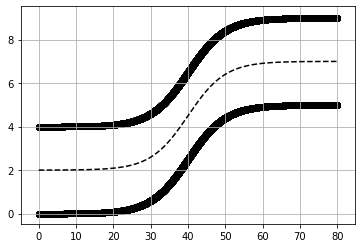

In [69]:
path = Road()
show_road(path)

In [70]:
# リスク
def calculate_lateral_error_by_risk_intermediate(ego_vehicle, path, t_preview, show=0):
    # 注視点
    d_preview = ego_vehicle.v * t_preview
    print(d_preview)
    x_pp = ego_vehicle.x + d_preview * np.cos(ego_vehicle.theta) # yawrate分は考えなくていい？
    y_pp = ego_vehicle.y + d_preview * np.sin(ego_vehicle.theta) # yawrate分は考えなくていい？
    theta_pp = ego_vehicle.yawrate * t_preview
    print(x_pp, y_pp, theta_pp)
    
    # リスク計算
    # (1)道路を注視点を中心に座標変換
    A = [
        [np.cos(-ego_vehicle.theta), -np.sin(-ego_vehicle.theta), 0],
        [np.sin(-ego_vehicle.theta), np.cos(-ego_vehicle.theta), 0],
        [0,0,1]
    ]
    
    # 道路
    X = np.array([path.x-x_pp, path.y_center-y_pp,1]).T
#     print(path.y_center)
#     print(y_pp)
#     print(X)
    plt.scatter(X[0], X[1])
    path_rotate = np.dot(A,X)
    
    # 注視点
    X0 = np.array([x_pp-x_pp, y_pp-y_pp,1]).T
    pp_rotate = np.dot(A,X0)
    
    # 描画
    plt.scatter(path_rotate[0], path_rotate[1])
    plt.scatter(pp_rotate[0], pp_rotate[1])
    plt.grid()
    
    # (2)左右道路までの距離を計算
    
    # (3)最小リスク点までの横偏差dyを計算
    
    return path_rotate

In [76]:
ego_vehicle = Vehicle()
A = [
        [np.cos(-ego_vehicle.theta), -np.sin(-ego_vehicle.theta), 0],
        [np.sin(-ego_vehicle.theta), np.cos(-ego_vehicle.theta), 0],
        [0,0,1]
    ]
print(A)
X = np.array([np.array([0,1,2,3]), np.array([3,2,1,0]),1]).T
np.dot(A,X)

[[1.0, -0.0, 0], [0.0, 1.0, 0], [0, 0, 1]]


array([array([0., 1., 2., 3.]), array([3., 2., 1., 0.]),
       array([1, 1, 1, 1])], dtype=object)

In [77]:
def U_w(dy):
    return 0.5*np.exp(-np.abs(dy)/0.5)

In [80]:
# リスク
def calculate_lateral_error_by_risk_global(ego_vehicle, path, t_preview, show=0):
    # 注視点
    d_preview = ego_vehicle.v * t_preview
    x_pp = ego_vehicle.x + d_preview * np.cos(ego_vehicle.theta) # yawrate分は考えなくていい？
    y_pp = ego_vehicle.y + d_preview * np.sin(ego_vehicle.theta) # yawrate分は考えなくていい？
    theta_pp = ego_vehicle.yawrate * t_preview
    
    # 各点（道路境界と参照パス）と直線（自車ー注視点を結ぶ直線に垂直）の距離が最小になる点　＝　車両の真横の道路境界・参照パスの点
    # ax+by+c=0
    if (np.tan(ego_vehicle.theta) < 0.01):
        a = 1e10
    else:
        a = 1/np.tan(ego_vehicle.theta)
    b = 1
    c = -(a*x_pp+y_pp)
    ind_center = np.argmin(np.abs(a*path.x + b*path.y_center + c) / np.sqrt(a*a + b*b))
    ind_left = np.argmin(np.abs(a*path.x + b*path.y_left + c) / np.sqrt(a*a + b*b))
    ind_right = np.argmin(np.abs(a*path.x + b*path.y_right + c) / np.sqrt(a*a + b*b))
    x_center, y_center, rho = path.x[ind_center], path.y_center[ind_center], path.rho[ind_center] 
    x_left, y_left = path.x[ind_left], path.y_left[ind_left] 
    x_right, y_right = path.x[ind_right], path.y_right[ind_right] 
    
    # 車線内の点を作成
    if(x_left == x_right):
        x = np.linspace(x_left, x_right, 50)
        y = np.linspace(y_left, y_right, 50)
    else:
        x = np.linspace(x_left, x_right, 50)
        y = -(a*x+c)/b
    
    # リスクを計算
    d_left = np.sqrt(np.power((x_left - x),2) + np.power((y_left - y),2))
    d_right = np.sqrt(np.power((x_right - x),2) + np.power((y_right - y),2))
    U = U_w(d_left) + U_w(d_right)
    print(rho)
    
    # 最小リスク点を計算
    x_minirisk, y_minirisk  = x[np.argmin(U)], y[np.argmin(U)]
    
    # 偏差を計算
    aa = -np.tan(ego_vehicle.theta)
    bb = 1
    cc = -(aa*x_pp + b*y_pp)
    dy = (aa*x_minirisk + bb*y_minirisk + cc) / np.sqrt(aa*aa + bb*bb)
    
    return dy

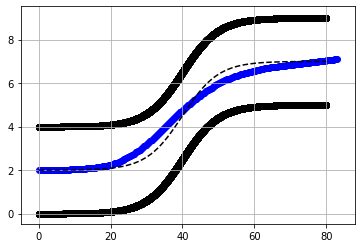

In [81]:
dt = 0.1
t_preview = 2.5
ego_vehicle = Vehicle(y=2)

show_road(path)

for i in range(150):
    # 危険感モデルによるヨーレイトの計算
    dy = calculate_lateral_error_by_risk_global(ego_vehicle, path, t_preview)
    gamma = 2*dy/(ego_vehicle.v*t_preview)
    
    plt.scatter(ego_vehicle.x, ego_vehicle.y, color='b')
    
    # 自車パラメータの更新
    ego_vehicle.theta = ego_vehicle.theta + gamma * dt
    ego_vehicle.x = ego_vehicle.x + np.cos(ego_vehicle.theta) * ego_vehicle.v * dt
    ego_vehicle.y = ego_vehicle.y + np.sin(ego_vehicle.theta) * ego_vehicle.v * dt
    
    plt.scatter(ego_vehicle.x, ego_vehicle.y, color='b')

# 前方注視モデル

In [10]:
# 前方注視モデル
def calculate_lateral_error(x, y, ori, d_preview, path_x, path_y, show=0):
    # 注視点
    x_pp = x + d_preview * np.cos(ori)
    y_pp = y + d_preview * np.sin(ori)

    # 点と直線（自車ー注視点を結ぶ）の距離が最小になる、パスを取得
    if (np.tan(ori) < 0.01):
        a = 1e10
    else:
        a = 1/np.tan(ori)
        
    b = 1
    c = -(a*x_pp+y_pp)
    d = np.abs(a*path_x + b*path_y + c) / np.sqrt(a*a + b*b)
    ind = np.argmin(d)
    
    
    if show:
        plt.scatter(x, y);
        plt.scatter(path_x, path_y)
        plt.scatter(x_pp, y_pp);
        plt.plot([x,x_pp],[y,y_pp],'k:')
        plt.scatter(path_x[ind],path_y[ind])
        plt.plot([x_pp,path_x[ind]],[y_pp,path_y[ind]],'k--')
        plt.xlabel('X[m]')
        plt.ylabel('Y[m]')
        
    aa = -np.tan(ori)
    bb = 1
    cc = -(aa*x_pp + b*y_pp)
    lat_error = (aa*path_x[ind] + bb*path_y[ind] + cc) / np.sqrt(aa*aa + bb*bb)
    
    return lat_error

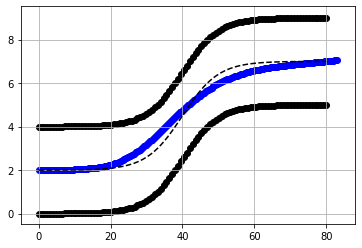

In [11]:
dt = 0.1
pre_t = 2.5
ego_vehicle = Vehicle(y=2)

show_road(path)

for i in range(150):
    # 前方注視モデルによるヨーレイトの計算
    preview_d = ego_vehicle.v*pre_t
    dy = calculate_lateral_error(ego_vehicle.x, ego_vehicle.y, ego_vehicle.theta, preview_d, path.x, path.y_center)
    gamma = 2*dy/(ego_vehicle.v*pre_t)
    
    plt.scatter(ego_vehicle.x, ego_vehicle.y, color='b')
    
    # 自車パラメータの更新
    ego_vehicle.theta = ego_vehicle.theta + gamma * dt
    ego_vehicle.x = ego_vehicle.x + np.cos(ego_vehicle.theta) * ego_vehicle.v * dt
    ego_vehicle.y = ego_vehicle.y + np.sin(ego_vehicle.theta) * ego_vehicle.v * dt
    
    plt.scatter(ego_vehicle.x, ego_vehicle.y, color='b')

In [12]:
def run_simulation(i):
    # 前方注視モデルによるヨーレイトの計算
    preview_d = ego_vehicle.v*pre_t
    dy = calculate_lateral_error(ego_vehicle.x, ego_vehicle.y, ego_vehicle.theta, preview_d, path.x, path.y_center,1)
    gamma = 2*dy/(ego_vehicle.v*pre_t)
    
    # 自車パラメータの更新
    ego_vehicle.theta = ego_vehicle.theta + gamma * dt
    ego_vehicle.x = ego_vehicle.x + np.cos(ego_vehicle.theta) * ego_vehicle.v * dt
    ego_vehicle.y = ego_vehicle.y + np.sin(ego_vehicle.theta) * ego_vehicle.v * dt
    
    # 表示
    ax.clear()
    ax.scatter(ego_vehicle.x, ego_vehicle.y)
    ax.plot(path.x, path.y_center,'k:')
    ax.plot(path.x, path.y_left,'k--')
    ax.plot(path.x, path.y_right,'k--')

    ax.set_xlim([ego_vehicle.x-10,ego_vehicle.x+10])
    ax.set_ylim([ego_vehicle.y-10,ego_vehicle.y+10])    
    ax.set_xlabel('X[m]')
    ax.set_ylabel('Y[m]')

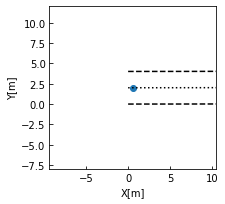

In [13]:
ego_vehicle = Vehicle(y=2)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
show_road(path)

run_simulation(0)
ax.tick_params(direction='in')

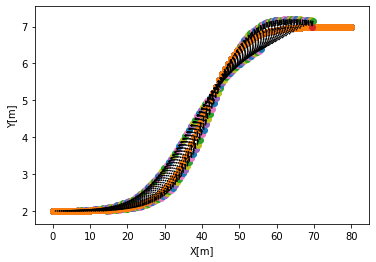

In [14]:
frames = list(range(100))
ani = anm.FuncAnimation(fig, run_simulation, frames=frames)
ani.save('preview-point-model.gif', writer='pillow', fps=10)